<a href="https://www.kaggle.com/code/ahmedrushdi/rl-pong-ddqn?scriptVersionId=121620565" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
!pip install gym[atari,accept-rom-license] #--quiet
!pip install pygame --quiet
!pip install pyvirtualdisplay --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 20.1 MB/s eta 0:00:00
  Installing build dependencies ... - \ | / - \ | / - \ | / - \ | / done
  Getting requirements to build wheel ... - done
  Preparing metadata (pyproject.toml) ... - done
  Using cached libtorrent-2.0.7-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (8.6 MB)
  Created wheel for AutoROM.accept-rom-license: filename=AutoROM.accept_rom_license-0.5.5-py3-none-any.whl size=448838 sha256=b33793744290db9ff07db60377325752660264a94521d4df7ea363895eaa88ea
  Stored in directory: /root/.cache/pip/wheels/ff/91/f8/f518dfff78fedfb9076d3439fe8b08c03ced911b2fefcd385e
Successfully built AutoROM.accept-rom-license


In [2]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1024, 768))
display.start()


from matplotlib import pyplot as plt, animation
%matplotlib inline
from IPython import display

def create_anim(frames, dpi, fps):
    plt.figure(figsize=(frames[0].shape[1] / dpi, frames[0].shape[0] / dpi), dpi=dpi)
    patch = plt.imshow(frames[0])
    def setup():
        plt.axis('off')
    def animate(i):
        patch.set_data(frames[i])
    anim = animation.FuncAnimation(plt.gcf(), animate, init_func=setup, frames=len(frames), interval=fps)
    return anim

def display_anim(frames, dpi=72, fps=50):
    anim = create_anim(frames, dpi, fps)
    return anim.to_jshtml()

def save_anim(frames, filename, dpi=72, fps=50):
    anim = create_anim(frames, dpi, fps)
    anim.save(filename)

In [3]:
from IPython.display import clear_output
import gym
import numpy as np
from tqdm.notebook import tqdm
from tensorflow import keras
import tensorflow as tf
from collections import deque
import random
from keras.backend import int_shape
from tensorflow.keras.models import load_model
import psutil

/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:585: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.object,
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:637: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.bool,
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/tensor_util.py:108: DeprecationWarning: `np.object` is a deprecated ali

In [4]:
env = gym.make('PongNoFrameskip-v4')
env = gym.wrappers.AtariPreprocessing(env, noop_max=30, frame_skip=4, screen_size=84, terminal_on_life_loss=False, grayscale_obs=True, grayscale_newaxis=False, scale_obs=True)
env = gym.wrappers.FrameStack(env, 4)

A.L.E: Arcade Learning Environment (version 0.7.5+db37282)
[Powered by Stella]


In [5]:
env.action_space

Discrete(6)

In [6]:
env.observation_space

Box(0.0, 1.0, (4, 84, 84), float32)

In [7]:
# number of frames to run
NUM_FRAMES = 2000000

#number of episodes to run
NUM_EPISODES = 100

#initial episode to continue training (0 if didn't train)
INIT_EPISODE = 100

#max iterations per run
MAX_ITERATIONS = 1000


#epsilon for choosing action
eps = 1 
eps_decay = 0.99

eps = eps*(eps_decay**INIT_EPISODE)

#discount factor for future utility
discount_factor = 0.97

#batch size for exp replay
batch_size = 32

#max memory stored for exp replay
MAX_MEMORY = int(NUM_FRAMES/40)

#initial population of memory using random policy
INIT_MEMORY = int(MAX_MEMORY*0.8)

#update interval to use target network
TARGET_C = int(NUM_FRAMES/1000)

In [8]:
class DQNAgent:
    def __init__(self, state_size, action_size):
#         import pdb; pdb.set_trace()
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=MAX_MEMORY)
        self.gamma = discount_factor    # discount rate
        self.epsilon = eps  # exploration rate
#         self.epsilon_min = eps_min
        self.epsilon_decay = eps_decay
        self.learning_rate = 0.00025
        self.model = self._build_model()
        self.target_model = self._build_model()
        self.update_target_model()
        
    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())
    def _build_model(self):
        model = keras.Sequential(
            [
                keras.layers.Permute((2,3,1), input_shape=self.state_size),
                keras.layers.Conv2D(16, kernel_size=(8, 8), strides=4, activation="relu",),
                keras.layers.Conv2D(32, kernel_size=(4, 4), strides=2, activation="relu"),
                keras.layers.Flatten(),
                keras.layers.Dense(256, activation="relu"),
                keras.layers.Dense(self.action_size, activation="linear"),
            ]
        )
        model.compile(loss='mse',
              optimizer=keras.optimizers.Adam(learning_rate=self.learning_rate))
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((np.expand_dims(state, axis=0), action, reward, np.expand_dims(next_state, axis=0), done))

    #get action
    def act(self, state):
        #select random action with prob=epsilon else action=maxQ
#         import pdb; pdb.set_trace()
        state = (np.expand_dims(state, axis=0))
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = self.model.predict(state)
        return np.argmax(act_values)
    
    def replay(self, batch_size):
        #sample random transitions
        
        state, action, reward, next_state, done = zip(*random.sample(self.memory, batch_size))
        state = np.concatenate(state)
        next_state = np.concatenate(next_state)
        action = np.array(action)
        reward = np.array(reward)
        done = np.array(done)
        Q_next=self.model.predict(next_state)
        states_target_q_values = self.target_model.predict(state)
        action_i = (np.arange(batch_size),action)
        n_action_i = (np.arange(batch_size),np.argmax(Q_next, axis=1))
#         import pdb; pdb.set_trace()
        target = reward + self.gamma * Q_next[n_action_i] * (1 - done)
        states_target_q_values[action_i] = target
        self.model.fit(state,states_target_q_values,epochs=1, verbose=0)
        
        
    def train(self, n_episodes, n_iterations):
        
        self.init_mem(INIT_MEMORY)
        scores = []
        iterations = []
        for i in tqdm(range(n_episodes), desc='Episodes'):
            state = env.reset()
            done = False
            score = 0
            frames = 0
            t = tqdm(range(n_iterations), leave=False, desc='iterations', total = 1000)
            for j in t:
                action = self.act(state)
                next_state, reward, done, info = env.step(action)
                self.remember(state, action, reward, next_state, done)
#                 if (j + 1)% (batch_size//4) == 0:
                self.replay(batch_size)
                if j % TARGET_C == 0:
                    
                    self.update_target_model()
                state = next_state
                score += reward
                self.epsilon *= self.epsilon_decay
                if done:
                    t.container.close()
                    iterations.append(j+1)
                    break
            scores.append(score)
            self.save_models()
            print(f'EP{i}: Done with status n_iter: {j+1}, mem_size: {len(self.memory)} {psutil.virtual_memory()}, score: {score}')
        return scores, iterations
    
    def init_mem(self, mem_n):
        for i in tqdm(range(mem_n//1000), desc = 'initializing memory'):
            state = env.reset()

            done = False
            t = tqdm(range(1000), leave=False, desc='iterations')
            for j in t:

                action = self.act(state)

                next_state, reward, done, info = env.step(action)

                self.remember(state, action, reward, next_state, done)

                state = next_state
                if done:
                    t.container.close()
                    break
        print(len(self.memory))
                
        
    def save_models(self):
        self.model.save('/kaggle/working/model.h5')        
        self.target_model.save('/kaggle/working/target_model.h5')
    
    def load_models(self, m_link, tm_link):
        self.model = load_model(m_link)        
        self.target_model = load_model(tm_link)



In [9]:
agent = DQNAgent(env.reset().shape,env.action_space.n)
agent.load_models("../input/pongmodel/model.h5","../input/pongmodel/target_model.h5")

initializing memory:   0%|          | 0/40 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

39945


Episodes:   0%|          | 0/100 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP0: Done with status n_iter: 934, mem_size: 40879 svmem(total=33669992448, available=22712041472, percent=32.5, used=10479771648, free=16832303104, active=1501855744, inactive=14688616448, buffers=1197326336, cached=5160591360, shared=995328, slab=494153728), score: -21.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP1: Done with status n_iter: 1000, mem_size: 41879 svmem(total=33669992448, available=22489239552, percent=33.2, used=10702663680, free=16588660736, active=1502117888, inactive=14934466560, buffers=1197580288, cached=5181087744, shared=995328, slab=494534656), score: -17.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP2: Done with status n_iter: 1000, mem_size: 42879 svmem(total=33669992448, available=22250319872, percent=33.9, used=10941579264, free=16337211392, active=1502347264, inactive=15187759104, buffers=1197809664, cached=5193392128, shared=995328, slab=495128576), score: -18.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP3: Done with status n_iter: 1000, mem_size: 43879 svmem(total=33669992448, available=22053883904, percent=34.5, used=11138023424, free=16135831552, active=1503105024, inactive=15417384960, buffers=1198063616, cached=5198073856, shared=995328, slab=495538176), score: -13.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP4: Done with status n_iter: 1000, mem_size: 44879 svmem(total=33669992448, available=21796016128, percent=35.3, used=11395891200, free=15876800512, active=1503350784, inactive=15662903296, buffers=1198309376, cached=5198991360, shared=995328, slab=495394816), score: -14.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP5: Done with status n_iter: 1000, mem_size: 45879 svmem(total=33669992448, available=21534588928, percent=36.0, used=11657318400, free=15614570496, active=1503629312, inactive=15917367296, buffers=1198571520, cached=5199532032, shared=995328, slab=495308800), score: -18.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP6: Done with status n_iter: 895, mem_size: 46774 svmem(total=33669992448, available=21312651264, percent=36.7, used=11879256064, free=15391940608, active=1503866880, inactive=16119812096, buffers=1198809088, cached=5199986688, shared=995328, slab=495284224), score: -20.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP7: Done with status n_iter: 1000, mem_size: 47774 svmem(total=33669992448, available=21082554368, percent=37.4, used=12109352960, free=15161016320, active=1504108544, inactive=16362577920, buffers=1199054848, cached=5200568320, shared=995328, slab=495517696), score: -12.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP8: Done with status n_iter: 1000, mem_size: 48774 svmem(total=33669992448, available=20920971264, percent=37.9, used=12270936064, free=14998614016, active=1504411648, inactive=16527540224, buffers=1199300608, cached=5201141760, shared=995328, slab=495648768), score: -15.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP9: Done with status n_iter: 1000, mem_size: 49774 svmem(total=33669992448, available=20648665088, percent=38.7, used=12543242240, free=14725382144, active=1504673792, inactive=16793833472, buffers=1199554560, cached=5201813504, shared=995328, slab=495493120), score: -10.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP10: Done with status n_iter: 1000, mem_size: 50000 svmem(total=33669992448, available=20580765696, percent=38.9, used=12611141632, free=14656712704, active=1504968704, inactive=16861454336, buffers=1199849472, cached=5202288640, shared=995328, slab=495616000), score: -9.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP11: Done with status n_iter: 1000, mem_size: 50000 svmem(total=33669992448, available=20572741632, percent=38.9, used=12619161600, free=14648082432, active=1505202176, inactive=16857788416, buffers=1200078848, cached=5202669568, shared=995328, slab=495718400), score: -8.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP12: Done with status n_iter: 1000, mem_size: 50000 svmem(total=33669992448, available=20579737600, percent=38.9, used=12612165632, free=14654595072, active=1505464320, inactive=16859643904, buffers=1200336896, cached=5202894848, shared=995328, slab=495783936), score: -6.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP13: Done with status n_iter: 1000, mem_size: 50000 svmem(total=33669992448, available=20581900288, percent=38.9, used=12610007040, free=14655860736, active=1505751040, inactive=16859914240, buffers=1200615424, cached=5203509248, shared=995328, slab=495640576), score: -14.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP14: Done with status n_iter: 1000, mem_size: 50000 svmem(total=33669992448, available=20558139392, percent=38.9, used=12633767936, free=14631424000, active=1506013184, inactive=16866095104, buffers=1200861184, cached=5203939328, shared=995328, slab=495652864), score: -11.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP15: Done with status n_iter: 1000, mem_size: 50000 svmem(total=33669992448, available=20549091328, percent=39.0, used=12642816000, free=14621360128, active=1506258944, inactive=16877604864, buffers=1201106944, cached=5204709376, shared=995328, slab=495906816), score: -15.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP16: Done with status n_iter: 1000, mem_size: 50000 svmem(total=33669992448, available=20546859008, percent=39.0, used=12645048320, free=14617997312, active=1506496512, inactive=16870096896, buffers=1201344512, cached=5205602304, shared=995328, slab=496189440), score: -10.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP17: Done with status n_iter: 1000, mem_size: 50000 svmem(total=33669992448, available=20549124096, percent=39.0, used=12642783232, free=14619160576, active=1507319808, inactive=16880500736, buffers=1201623040, cached=5206425600, shared=995328, slab=495853568), score: -8.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP18: Done with status n_iter: 1000, mem_size: 50000 svmem(total=33669992448, available=20534681600, percent=39.0, used=12657225728, free=14603632640, active=1507573760, inactive=16884736000, buffers=1201868800, cached=5207265280, shared=995328, slab=495984640), score: -7.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP19: Done with status n_iter: 1000, mem_size: 50000 svmem(total=33669992448, available=20546162688, percent=39.0, used=12645744640, free=14614016000, active=1507840000, inactive=16879550464, buffers=1202130944, cached=5208100864, shared=995328, slab=496242688), score: -12.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP20: Done with status n_iter: 1000, mem_size: 50000 svmem(total=33669992448, available=20547121152, percent=39.0, used=12644786176, free=14613704704, active=1508143104, inactive=16883458048, buffers=1202429952, cached=5209071616, shared=995328, slab=496074752), score: -8.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP21: Done with status n_iter: 1000, mem_size: 50000 svmem(total=33669992448, available=20542898176, percent=39.0, used=12649009152, free=14608461824, active=1508376576, inactive=16881000448, buffers=1202667520, cached=5209853952, shared=995328, slab=496029696), score: -16.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP22: Done with status n_iter: 1000, mem_size: 50000 svmem(total=33669992448, available=20547723264, percent=39.0, used=12644184064, free=14612279296, active=1508622336, inactive=16883777536, buffers=1202913280, cached=5210615808, shared=995328, slab=496218112), score: -5.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP23: Done with status n_iter: 1000, mem_size: 50000 svmem(total=33669992448, available=20551327744, percent=39.0, used=12640579584, free=14614716416, active=1508904960, inactive=16893132800, buffers=1203191808, cached=5211504640, shared=995328, slab=496558080), score: -3.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP24: Done with status n_iter: 1000, mem_size: 50000 svmem(total=33669992448, available=20552011776, percent=39.0, used=12639895552, free=14614278144, active=1509154816, inactive=16890527744, buffers=1203453952, cached=5212364800, shared=995328, slab=496156672), score: -6.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP25: Done with status n_iter: 1000, mem_size: 50000 svmem(total=33669992448, available=20523552768, percent=39.0, used=12668354560, free=14584680448, active=1509457920, inactive=16900403200, buffers=1203724288, cached=5213233152, shared=995328, slab=496279552), score: -4.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP26: Done with status n_iter: 1000, mem_size: 50000 svmem(total=33669992448, available=20534849536, percent=39.0, used=12657057792, free=14594859008, active=1509728256, inactive=16898555904, buffers=1203994624, cached=5214081024, shared=995328, slab=496435200), score: -5.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP27: Done with status n_iter: 1000, mem_size: 50000 svmem(total=33669992448, available=20540268544, percent=39.0, used=12651638784, free=14599606272, active=1509982208, inactive=16893308928, buffers=1204248576, cached=5214498816, shared=995328, slab=496623616), score: -3.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP28: Done with status n_iter: 1000, mem_size: 50000 svmem(total=33669992448, available=20567724032, percent=38.9, used=12624183296, free=14626471936, active=1510244352, inactive=16867680256, buffers=1204510720, cached=5214826496, shared=995328, slab=496414720), score: -6.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP29: Done with status n_iter: 1000, mem_size: 50000 svmem(total=33669992448, available=20552278016, percent=39.0, used=12639600640, free=14610333696, active=1510502400, inactive=16895258624, buffers=1204764672, cached=5215293440, shared=995328, slab=496467968), score: -9.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP30: Done with status n_iter: 1000, mem_size: 50000 svmem(total=33669992448, available=20527005696, percent=39.0, used=12664901632, free=14584373248, active=1511075840, inactive=16907567104, buffers=1205026816, cached=5215690752, shared=995328, slab=496766976), score: -3.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP31: Done with status n_iter: 1000, mem_size: 50000 svmem(total=33669992448, available=20568158208, percent=38.9, used=12623749120, free=14624763904, active=1511350272, inactive=16865738752, buffers=1205288960, cached=5216190464, shared=995328, slab=496701440), score: -3.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP32: Done with status n_iter: 1000, mem_size: 50000 svmem(total=33669992448, available=20513996800, percent=39.1, used=12677910528, free=14570074112, active=1511587840, inactive=16915320832, buffers=1205526528, cached=5216481280, shared=995328, slab=496599040), score: -4.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP33: Done with status n_iter: 1000, mem_size: 50000 svmem(total=33669992448, available=20528607232, percent=39.0, used=12663300096, free=14584152064, active=1511849984, inactive=16914731008, buffers=1205788672, cached=5216751616, shared=995328, slab=496771072), score: -12.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP34: Done with status n_iter: 1000, mem_size: 50000 svmem(total=33669992448, available=20534030336, percent=39.0, used=12657876992, free=14588989440, active=1512095744, inactive=16903888896, buffers=1206026240, cached=5217099776, shared=995328, slab=497049600), score: -5.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP35: Done with status n_iter: 1000, mem_size: 50000 svmem(total=33669992448, available=20547510272, percent=39.0, used=12644397056, free=14601936896, active=1512341504, inactive=16903659520, buffers=1206272000, cached=5217386496, shared=995328, slab=496766976), score: -5.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP36: Done with status n_iter: 1000, mem_size: 50000 svmem(total=33669992448, available=20541669376, percent=39.0, used=12650237952, free=14595506176, active=1512611840, inactive=16906043392, buffers=1206542336, cached=5217705984, shared=995328, slab=496947200), score: -3.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP37: Done with status n_iter: 1000, mem_size: 50000 svmem(total=33669992448, available=20532977664, percent=39.0, used=12658929664, free=14586257408, active=1512873984, inactive=16912793600, buffers=1206804480, cached=5218000896, shared=995328, slab=497135616), score: -4.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP38: Done with status n_iter: 1000, mem_size: 50000 svmem(total=33669992448, available=20509523968, percent=39.1, used=12682383360, free=14562332672, active=1513103360, inactive=16924000256, buffers=1207033856, cached=5218242560, shared=995328, slab=496951296), score: 3.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP39: Done with status n_iter: 1000, mem_size: 50000 svmem(total=33669992448, available=20523245568, percent=39.0, used=12668661760, free=14575542272, active=1513349120, inactive=16926060544, buffers=1207279616, cached=5218508800, shared=995328, slab=496877568), score: -6.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP40: Done with status n_iter: 1000, mem_size: 50000 svmem(total=33669992448, available=20526903296, percent=39.0, used=12665004032, free=14578622464, active=1513619456, inactive=16907644928, buffers=1207549952, cached=5218816000, shared=995328, slab=496975872), score: -6.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP41: Done with status n_iter: 1000, mem_size: 50000 svmem(total=33669992448, available=20525658112, percent=39.0, used=12666249216, free=14576869376, active=1513873408, inactive=16915480576, buffers=1207803904, cached=5219069952, shared=995328, slab=497209344), score: 1.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP42: Done with status n_iter: 1000, mem_size: 50000 svmem(total=33669992448, available=20524429312, percent=39.0, used=12667478016, free=14575153152, active=1514131456, inactive=16914616320, buffers=1208057856, cached=5219303424, shared=995328, slab=497057792), score: -5.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP43: Done with status n_iter: 1000, mem_size: 50000 svmem(total=33669992448, available=20560605184, percent=38.9, used=12631302144, free=14610780160, active=1514393600, inactive=16883634176, buffers=1208320000, cached=5219590144, shared=995328, slab=497053696), score: -5.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP44: Done with status n_iter: 1000, mem_size: 50000 svmem(total=33669992448, available=20546789376, percent=39.0, used=12645117952, free=14596448256, active=1514651648, inactive=16895680512, buffers=1208573952, cached=5219852288, shared=995328, slab=497192960), score: -3.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP45: Done with status n_iter: 1000, mem_size: 50000 svmem(total=33669992448, available=20504752128, percent=39.1, used=12687155200, free=14553784320, active=1514938368, inactive=16926425088, buffers=1208852480, cached=5220200448, shared=995328, slab=497397760), score: -7.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP46: Done with status n_iter: 1000, mem_size: 50000 svmem(total=33669992448, available=20499509248, percent=39.1, used=12692398080, free=14548021248, active=1515175936, inactive=16936607744, buffers=1209114624, cached=5220458496, shared=995328, slab=497209344), score: -6.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP47: Done with status n_iter: 1000, mem_size: 50000 svmem(total=33669992448, available=20488826880, percent=39.1, used=12703080448, free=14536810496, active=1515438080, inactive=16940789760, buffers=1209352192, cached=5220749312, shared=995328, slab=497213440), score: -6.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP48: Done with status n_iter: 1000, mem_size: 50000 svmem(total=33669992448, available=20533514240, percent=39.0, used=12658393088, free=14581010432, active=1515687936, inactive=16932515840, buffers=1209602048, cached=5220986880, shared=995328, slab=497340416), score: -8.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP49: Done with status n_iter: 1000, mem_size: 50000 svmem(total=33669992448, available=20516864000, percent=39.1, used=12675043328, free=14563622912, active=1515986944, inactive=16932978688, buffers=1209901056, cached=5221425152, shared=995328, slab=497631232), score: -4.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP50: Done with status n_iter: 1000, mem_size: 50000 svmem(total=33669992448, available=20491141120, percent=39.1, used=12700766208, free=14537396224, active=1516257280, inactive=16946925568, buffers=1210171392, cached=5221658624, shared=995328, slab=497291264), score: -4.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP51: Done with status n_iter: 1000, mem_size: 50000 svmem(total=33669992448, available=20558684160, percent=38.9, used=12633223168, free=14604451840, active=1516519424, inactive=16909819904, buffers=1210429440, cached=5221888000, shared=995328, slab=497344512), score: -5.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP52: Done with status n_iter: 1000, mem_size: 50000 svmem(total=33669992448, available=20502347776, percent=39.1, used=12689559552, free=14547611648, active=1516765184, inactive=16933974016, buffers=1210675200, cached=5222146048, shared=995328, slab=497512448), score: -4.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP53: Done with status n_iter: 1000, mem_size: 50000 svmem(total=33669992448, available=20533878784, percent=39.0, used=12658028544, free=14578581504, active=1517019136, inactive=16910159872, buffers=1210929152, cached=5222453248, shared=995328, slab=497684480), score: 0.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP54: Done with status n_iter: 1000, mem_size: 50000 svmem(total=33669992448, available=20489842688, percent=39.1, used=12702064640, free=14533967872, active=1517297664, inactive=16945065984, buffers=1211207680, cached=5222752256, shared=995328, slab=497410048), score: -2.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP55: Done with status n_iter: 1000, mem_size: 50000 svmem(total=33669992448, available=20486815744, percent=39.2, used=12705091584, free=14530453504, active=1517543424, inactive=16944025600, buffers=1211453440, cached=5222993920, shared=995328, slab=497459200), score: -4.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP56: Done with status n_iter: 1000, mem_size: 50000 svmem(total=33669992448, available=20488970240, percent=39.1, used=12702937088, free=14532124672, active=1517785088, inactive=16945307648, buffers=1211695104, cached=5223235584, shared=995328, slab=497664000), score: 1.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP57: Done with status n_iter: 1000, mem_size: 50000 svmem(total=33669992448, available=20494929920, percent=39.1, used=12696977408, free=14537580544, active=1518010368, inactive=16943120384, buffers=1211920384, cached=5223514112, shared=995328, slab=497434624), score: -1.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP58: Done with status n_iter: 1000, mem_size: 50000 svmem(total=33669992448, available=20491579392, percent=39.1, used=12700327936, free=14533705728, active=1518333952, inactive=16947318784, buffers=1212190720, cached=5223768064, shared=995328, slab=497491968), score: -3.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP59: Done with status n_iter: 1000, mem_size: 50000 svmem(total=33669992448, available=20487852032, percent=39.2, used=12704055296, free=14529470464, active=1518583808, inactive=16949088256, buffers=1212436480, cached=5224030208, shared=995328, slab=497635328), score: -3.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP60: Done with status n_iter: 1000, mem_size: 50000 svmem(total=33669992448, available=20526596096, percent=39.0, used=12665311232, free=14567657472, active=1518821376, inactive=16913301504, buffers=1212674048, cached=5224349696, shared=995328, slab=497934336), score: -4.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP61: Done with status n_iter: 1000, mem_size: 50000 svmem(total=33669992448, available=20480475136, percent=39.2, used=12711432192, free=14520918016, active=1519099904, inactive=16951726080, buffers=1212952576, cached=5224689664, shared=995328, slab=497643520), score: 1.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP62: Done with status n_iter: 1000, mem_size: 50000 svmem(total=33669992448, available=20496543744, percent=39.1, used=12695363584, free=14536544256, active=1519345664, inactive=16950546432, buffers=1213198336, cached=5224886272, shared=995328, slab=497725440), score: -4.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP63: Done with status n_iter: 1000, mem_size: 50000 svmem(total=33669992448, available=20536872960, percent=39.0, used=12655034368, free=14576340992, active=1519595520, inactive=16921456640, buffers=1213448192, cached=5225168896, shared=995328, slab=497917952), score: -3.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP64: Done with status n_iter: 1000, mem_size: 50000 svmem(total=33669992448, available=20486262784, percent=39.2, used=12705644544, free=14525198336, active=1519865856, inactive=16948588544, buffers=1213718528, cached=5225431040, shared=995328, slab=498016256), score: -2.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP65: Done with status n_iter: 1000, mem_size: 50000 svmem(total=33669992448, available=20494462976, percent=39.1, used=12697444352, free=14532878336, active=1520111616, inactive=16956882944, buffers=1213964288, cached=5225705472, shared=995328, slab=497729536), score: 2.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP66: Done with status n_iter: 1000, mem_size: 50000 svmem(total=33669992448, available=20482580480, percent=39.2, used=12709326848, free=14520455168, active=1520365568, inactive=16960581632, buffers=1214218240, cached=5225992192, shared=995328, slab=497799168), score: -6.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP67: Done with status n_iter: 1000, mem_size: 50000 svmem(total=33669992448, available=20493271040, percent=39.1, used=12698636288, free=14530519040, active=1520627712, inactive=16952643584, buffers=1214480384, cached=5226356736, shared=995328, slab=498098176), score: -2.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP68: Done with status n_iter: 1000, mem_size: 50000 svmem(total=33669992448, available=20474437632, percent=39.2, used=12717469696, free=14511206400, active=1520881664, inactive=16959123456, buffers=1214734336, cached=5226582016, shared=995328, slab=497782784), score: -4.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP69: Done with status n_iter: 1000, mem_size: 50000 svmem(total=33669992448, available=20470353920, percent=39.2, used=12721553408, free=14506717184, active=1521049600, inactive=16963141632, buffers=1214902272, cached=5226819584, shared=995328, slab=497897472), score: -5.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP70: Done with status n_iter: 1000, mem_size: 50000 svmem(total=33669992448, available=20482666496, percent=39.2, used=12709240832, free=14518583296, active=1521238016, inactive=16963276800, buffers=1215090688, cached=5227077632, shared=995328, slab=497967104), score: 1.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP71: Done with status n_iter: 1000, mem_size: 50000 svmem(total=33669992448, available=20460584960, percent=39.2, used=12731322368, free=14495993856, active=1521442816, inactive=16975048704, buffers=1215295488, cached=5227380736, shared=995328, slab=498229248), score: -2.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP72: Done with status n_iter: 1000, mem_size: 50000 svmem(total=33669992448, available=20464492544, percent=39.2, used=12727410688, free=14499414016, active=1521635328, inactive=16970031104, buffers=1215475712, cached=5227692032, shared=995328, slab=497987584), score: 0.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP73: Done with status n_iter: 1000, mem_size: 50000 svmem(total=33669992448, available=20483149824, percent=39.2, used=12708757504, free=14517608448, active=1521819648, inactive=16964771840, buffers=1215660032, cached=5227966464, shared=995328, slab=497987584), score: -5.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP74: Done with status n_iter: 1000, mem_size: 50000 svmem(total=33669992448, available=20469149696, percent=39.2, used=12722757632, free=14503133184, active=1522003968, inactive=16974020608, buffers=1215844352, cached=5228257280, shared=995328, slab=498225152), score: -5.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP75: Done with status n_iter: 1000, mem_size: 50000 svmem(total=33669992448, available=20487233536, percent=39.2, used=12704673792, free=14520782848, active=1522200576, inactive=16965558272, buffers=1216036864, cached=5228498944, shared=995328, slab=498446336), score: -2.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP76: Done with status n_iter: 1000, mem_size: 50000 svmem(total=33669992448, available=20463370240, percent=39.2, used=12728537088, free=14496428032, active=1522405376, inactive=16974327808, buffers=1216241664, cached=5228785664, shared=995328, slab=498151424), score: -5.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP77: Done with status n_iter: 1000, mem_size: 50000 svmem(total=33669992448, available=20483727360, percent=39.2, used=12708179968, free=14516375552, active=1522589696, inactive=16976441344, buffers=1216425984, cached=5229010944, shared=995328, slab=498143232), score: -5.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP78: Done with status n_iter: 1000, mem_size: 50000 svmem(total=33669992448, available=20472713216, percent=39.2, used=12719194112, free=14504898560, active=1522782208, inactive=16979238912, buffers=1216618496, cached=5229281280, shared=995328, slab=498417664), score: -5.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP79: Done with status n_iter: 1000, mem_size: 50000 svmem(total=33669992448, available=20472741888, percent=39.2, used=12719165440, free=14504476672, active=1522966528, inactive=16973754368, buffers=1216802816, cached=5229547520, shared=995328, slab=498229248), score: -3.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP80: Done with status n_iter: 1000, mem_size: 50000 svmem(total=33669992448, available=20466171904, percent=39.2, used=12725735424, free=14497439744, active=1523163136, inactive=16979894272, buffers=1216999424, cached=5229817856, shared=995328, slab=498237440), score: -2.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP81: Done with status n_iter: 1000, mem_size: 50000 svmem(total=33669992448, available=20464103424, percent=39.2, used=12727803904, free=14494875648, active=1523376128, inactive=16980262912, buffers=1217212416, cached=5230100480, shared=995328, slab=498409472), score: -7.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP82: Done with status n_iter: 1000, mem_size: 50000 svmem(total=33669992448, available=20466253824, percent=39.2, used=12725641216, free=14496526336, active=1523580928, inactive=16983494656, buffers=1217429504, cached=5230395392, shared=995328, slab=498544640), score: 0.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP83: Done with status n_iter: 1000, mem_size: 50000 svmem(total=33669992448, available=20468666368, percent=39.2, used=12723240960, free=14498463744, active=1523793920, inactive=16988553216, buffers=1217630208, cached=5230657536, shared=995328, slab=498356224), score: -1.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP84: Done with status n_iter: 1000, mem_size: 50000 svmem(total=33669992448, available=20466868224, percent=39.2, used=12725039104, free=14496169984, active=1524006912, inactive=16979599360, buffers=1217843200, cached=5230940160, shared=995328, slab=498421760), score: -3.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP85: Done with status n_iter: 1000, mem_size: 50000 svmem(total=33669992448, available=20449316864, percent=39.3, used=12742590464, free=14478065664, active=1524334592, inactive=16993185792, buffers=1218117632, cached=5231218688, shared=995328, slab=498569216), score: -8.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP86: Done with status n_iter: 1000, mem_size: 50000 svmem(total=33669992448, available=20448677888, percent=39.3, used=12743229440, free=14476910592, active=1524600832, inactive=16996790272, buffers=1218383872, cached=5231468544, shared=995328, slab=498704384), score: -2.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP87: Done with status n_iter: 1000, mem_size: 50000 svmem(total=33669992448, available=20456366080, percent=39.2, used=12735541248, free=14484152320, active=1524781056, inactive=16991576064, buffers=1218564096, cached=5231734784, shared=995328, slab=498458624), score: -2.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP88: Done with status n_iter: 1000, mem_size: 50000 svmem(total=33669992448, available=20469526528, percent=39.2, used=12722380800, free=14496849920, active=1524977664, inactive=16994308096, buffers=1218760704, cached=5232001024, shared=995328, slab=498425856), score: -6.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP89: Done with status n_iter: 1000, mem_size: 50000 svmem(total=33669992448, available=20461326336, percent=39.2, used=12730580992, free=14488211456, active=1525149696, inactive=16992845824, buffers=1218932736, cached=5232267264, shared=995328, slab=498663424), score: -1.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP90: Done with status n_iter: 1000, mem_size: 50000 svmem(total=33669992448, available=20446072832, percent=39.3, used=12745834496, free=14472544256, active=1525321728, inactive=16998060032, buffers=1219104768, cached=5232508928, shared=995328, slab=498835456), score: -2.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP91: Done with status n_iter: 1000, mem_size: 50000 svmem(total=33669992448, available=20442533888, percent=39.3, used=12749373440, free=14468534272, active=1525518336, inactive=17002684416, buffers=1219301376, cached=5232783360, shared=995328, slab=498540544), score: 0.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP92: Done with status n_iter: 1000, mem_size: 50000 svmem(total=33669992448, available=20448894976, percent=39.3, used=12743012352, free=14474403840, active=1525714944, inactive=16996724736, buffers=1219497984, cached=5233078272, shared=995328, slab=498659328), score: -3.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP93: Done with status n_iter: 1000, mem_size: 50000 svmem(total=33669992448, available=20474212352, percent=39.2, used=12717694976, free=14499241984, active=1525911552, inactive=16966389760, buffers=1219694592, cached=5233360896, shared=995328, slab=498888704), score: 2.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP94: Done with status n_iter: 1000, mem_size: 50000 svmem(total=33669992448, available=20450189312, percent=39.3, used=12741718016, free=14474784768, active=1526124544, inactive=17004687360, buffers=1219907584, cached=5233582080, shared=995328, slab=498647040), score: -8.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP95: Done with status n_iter: 1000, mem_size: 50000 svmem(total=33669992448, available=20467531776, percent=39.2, used=12724375552, free=14491611136, active=1526321152, inactive=16998715392, buffers=1220104192, cached=5233901568, shared=995328, slab=498667520), score: -2.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP96: Done with status n_iter: 1000, mem_size: 50000 svmem(total=33669992448, available=20441948160, percent=39.3, used=12749959168, free=14465511424, active=1526505472, inactive=17009004544, buffers=1220288512, cached=5234233344, shared=995328, slab=498847744), score: -2.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP97: Done with status n_iter: 1000, mem_size: 50000 svmem(total=33669992448, available=20443090944, percent=39.3, used=12748816384, free=14466080768, active=1526714368, inactive=17010384896, buffers=1220497408, cached=5234597888, shared=995328, slab=499105792), score: -8.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP98: Done with status n_iter: 1000, mem_size: 50000 svmem(total=33669992448, available=20434931712, percent=39.3, used=12756975616, free=14457589760, active=1526898688, inactive=17008844800, buffers=1220681728, cached=5234745344, shared=995328, slab=498802688), score: -5.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP99: Done with status n_iter: 1000, mem_size: 50000 svmem(total=33669992448, available=20481273856, percent=39.2, used=12710633472, free=14503464960, active=1527132160, inactive=16978194432, buffers=1220907008, cached=5234987008, shared=995328, slab=498819072), score: 1.0


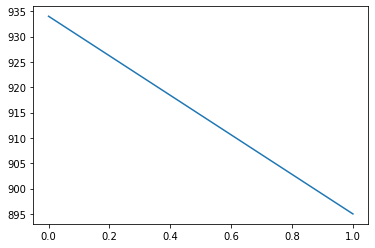

In [10]:
scores, n_iters = agent.train(NUM_EPISODES, MAX_ITERATIONS)
plt.plot(n_iters)

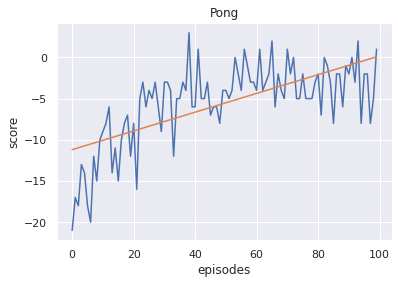

In [11]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns

sns.set()

plt.plot(scores)
plt.ylabel('score')
plt.xlabel('episodes')
plt.title('Pong')

reg = LinearRegression().fit(np.arange(len(scores)).reshape(-1, 1), np.array(scores).reshape(-1, 1))
y_pred = reg.predict(np.arange(len(scores)).reshape(-1, 1))
plt.plot(y_pred)
plt.show()

In [12]:
from IPython.display import FileLink
FileLink(r'/kaggle/working/model.h5')

/kaggle/working/model.h5

In [13]:
FileLink(r'/kaggle/working/target_model.h5')

/kaggle/working/target_model.h5